In [48]:
!pip install -Uqq fastai duckduckgo_search

# DDG API documentation
# https://pypi.org/project/duckduckgo-search/#3-images---image-search-by-duckduckgocom
from fastcore.all import *
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import *
from duckduckgo_search import DDGS
import os

In [49]:
# helpful functions to DRY

# need to make sure this is closed later on
def search_ddg(search_terms):
    ddgs = DDGS()
    return ddgs.images(
        keywords = search_terms,
        region="wt-wt",
        safesearch="moderate",
        type_image="photo",
    )

In [50]:
categories = 'dolphin', 'manatee', 'turtle', 'whale'
generators = {}
for category in categories:
    generators[category] = search_ddg(category)
    
print(next(generators['dolphin']))
print(next(generators['manatee']))
print(next(generators['whale']))
print(next(generators['turtle']))

{'title': 'Dolphin 4k Ultra HD Wallpaper', 'image': 'https://images.alphacoders.com/293/293531.jpg', 'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.iEJ06_DV_5PHBbDWIZ6ZqQHaF1&pid=Api', 'url': 'https://wall.alphacoders.com/big.php?i=293531', 'height': 3781, 'width': 4800, 'source': 'Bing'}
{'title': 'Manatees were once important Seminole food source • The Seminole Tribune', 'image': 'http://seminoletribune.org/wp-content/uploads/2019/04/Manatee-1.jpg', 'thumbnail': 'https://tse1.mm.bing.net/th?id=OIP.x31nae0GHXce_eSC5-KnIAHaE8&pid=Api', 'url': 'https://seminoletribune.org/manatees-were-once-important-seminole-food-source/', 'height': 1600, 'width': 2400, 'source': 'Bing'}
{'title': 'Fascinating Humpback Whale Facts', 'image': 'https://fthmb.tqn.com/l1vhEscfQQUiCi9W8ZpJ79vc144=/5200x3313/filters:fill(auto,1)/humpback-whale-underwater-portrait--107312834-5a01c2cab39d03001952917f.jpg', 'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.ex5KYElGdSup7eoO0fMIwQHaEt&pid=Api', 'url': 'https://w

Just for fun, download a few images

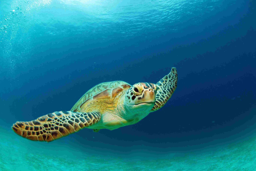

In [51]:
for animal in categories:
    gen = generators[animal]
    name = animal + '.jpg'
    download_url(next(gen)['image'], name, show_progress=False)
    Image.open(name).to_thumb(256,256)

Image.open('turtle.jpg').to_thumb(256,256)

In [52]:
def get_n_urls (generator, n):
    items=[]
    for i in range(n):
        try:
            items.append(next(generator)['image'])
        except StopIteration:
            break
    return items

## *WARNING* - If you have bad data and want to replace it you may need to delete the files. New files are not downloaded if the folder has >=50. Or you could change the value of images_per_folder

This is not perfect as the ddg_search sometimes returns less than the number of items requested. But it will prevent wasting time downloading pictures to an extent.

In [53]:
images_per_folder = 50 # how many images each search downloads

path = Path('lesson1/training_images')

for category in categories:
    dest = (path/category)
    dest.mkdir(exist_ok=True, parents=true)
    if len(os.listdir(str(dest))) < images_per_folder:
        print(f"downloading {category}")
        gen = generators[category]
        download_images(dest, urls=get_n_urls(gen, images_per_folder))
        resize_images(path/category, max_size=400, dest=path/category)

In [54]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

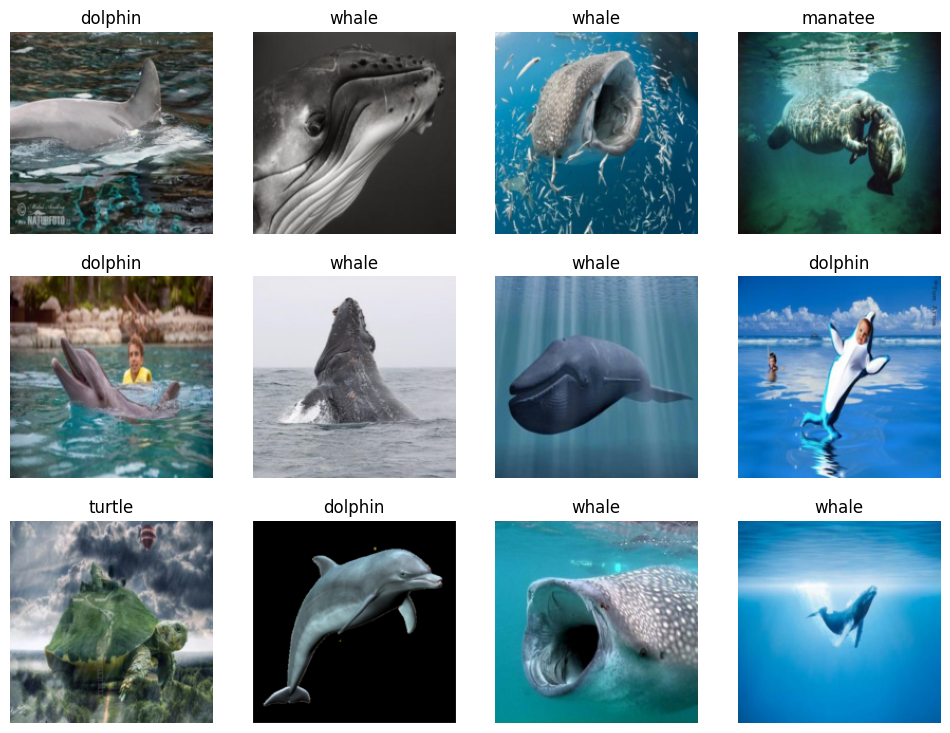

In [55]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [56]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Now we download data that should not match the model. After that we will run predictions

In [57]:
# Should not match at all
dogs = search_ddg('dog')
dog = next(dogs)
download_url(dog['image'], 'dog.jpg', show_progress=False)

# Might match or partially match the model vs dolphins or whales
sharks = search_ddg('shark')
shark = next(sharks)
download_url(shark['image'], 'shark.jpg', show_progress=False)

Path('shark.jpg')

Now we compare our images vs the model and see what it predicts.

In [58]:
def get_subdirectories(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

# Usage
directories=get_subdirectories('lesson1/training_images')
print(directories)  # Replace with your directory
print(sorted(directories))
print(categories)

['turtle', 'manatee', 'whale', 'dolphin']
['dolphin', 'manatee', 'turtle', 'whale']
('dolphin', 'manatee', 'turtle', 'whale')


In [63]:
# WRT probs[n]
# dolphin is index 0
# manatee is 1
# turtle is 2
# whale is 3

for animal in categories:
    is_x,_,probs = learn.predict(PILImage.create(f"{animal}.jpg"))
    print(f"This is a {animal}")
    print(f"Probability it's a {animal}: {probs[3]:.4f}")

This is a dolphin
Probability it's a dolphin: 0.1281


This is a manatee
Probability it's a manatee: 0.0000


This is a turtle
Probability it's a turtle: 0.2591


This is a whale
Probability it's a whale: 0.8801


Lastly, we need to close all the generators used